# Continuous Control

---

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment.  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='../Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    statprintes = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.20399999544024466


### 4. Train the Agent with DDPG

Now we improve the performance of the agent using DDPG.

In [5]:
import torch
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def train(n_episodes=2000, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores_window = deque(maxlen=100)  # A list that stores max. 100 latest scores
    average_scores = []                # A list that stores average scores over 20 agents
    moving_average_scores = []         # A list that stores moving average scores over episodes over 20 agents
    all_scores = []                    # A list that stores all scores for each agent
    print("Training performance:")
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]   # reset the environment
        states = env_info.vector_observations               # get the current state (for each agent)
        scores = np.zeros(num_agents)                       # initialize the score (for each agent)

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations      # get the next state
            rewards = env_info.rewards                      # get the reward
            dones = env_info.local_done                     # see if episode has finished
            scores += rewards                               # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
                
        scores_window.append(np.mean(scores))   # save most recent averaged score (max. 100)
        average_scores.append(np.mean(scores))  # save all average scores over 20 agents
        moving_average_scores.append(np.mean(scores_window)) # save the moving average scores over episodes
        all_scores.append(scores)               # save all scores for each agent
  
        print('\rEpisode {}\tAverage Score: {:.2f} \tMoving Average Score (lastest 100): {:.2f}'.format(i_episode, np.mean(scores), np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tMoving Average Score (lastest 100): {:.2f}'.format(i_episode, np.mean(scores), np.mean(scores_window)))
        if len(scores_window) == 100:
            if np.mean(scores_window)>=30:
                print('\nEnvironment solved in {:d} episodes!\tMoving Average Score (lastest 100): {:.2f}'.format(i_episode, np.mean(scores_window)))
                checkpoint = {
                    "actor_local_weights": agent.actor_local.state_dict(),
                    "critic_local_weights": agent.critic_local.state_dict(),
                    "average_scores": average_scores,
                    "moving_average_scores": moving_average_scores,
                    "all_scores": all_scores,
                    "episode": i_episode
                }
                torch.save(checkpoint, './checkpoint.pth')
                break
    return average_scores, moving_average_scores, all_scores

In [7]:
%%time

# Initialize DDPG agent
agent = Agent(state_size=env_info.vector_observations.shape[1],
              action_size=brain.vector_action_space_size, random_seed=0)

# Start training
average_scores, moving_average_scores, all_scores = train()

Hyperparameters:
{'BATCH_SIZE': 128,
 'BUFFER_SIZE': 100000,
 'GAMMA': 0.99,
 'LR_ACTOR': 0.001,
 'LR_CRITIC': 0.001,
 'NOISE_DECAY': 0.999,
 'TAU': 0.01,
 'UPDATE_EVERY': 5,
 'WEIGHT_DECAY': 1e-07}

Actor network:
 DataParallel(
  (module): Actor(
    (fc1): Linear(in_features=33, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=4, bias=True)
  )
)

Critic network:
 DataParallel(
  (module): Critic(
    (fcs1): Linear(in_features=33, out_features=256, bias=True)
    (fc2): Linear(in_features=260, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=1, bias=True)
  )
)

Training performance:
Episode 10	Average Score: 2.17 	Moving Average Score (lastest 100): 1.07
Episode 20	Average Score: 4.34 	Moving Average Score (lastest 100): 2.47
Episode 30	Average Score: 8.04 	Moving Average Score (lastest 100): 4.16
Episode 40	Average Score: 10.32 	Moving Average Score (lastest 100

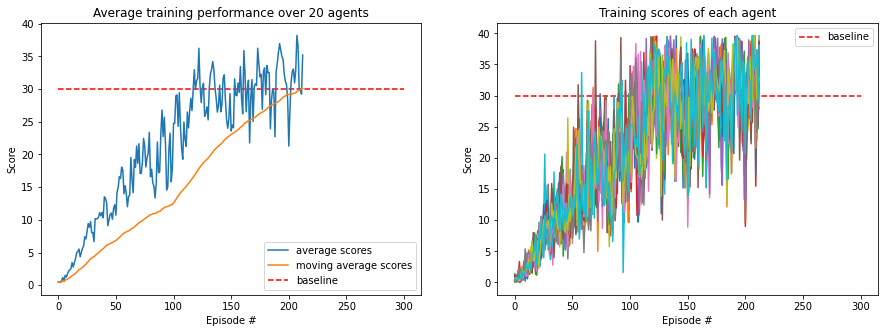

In [8]:
# plot the average scores over 20 agents
fig = plt.figure(figsize=(15,5))
fig1 = plt.subplot(1,2,1)
plt.plot(np.arange(len(average_scores)), average_scores, label="average scores")
plt.hlines(30, 0, 300, colors="r", linestyles="dashed", label="baseline")
plt.plot(np.arange(len(moving_average_scores)), moving_average_scores, label="moving average scores")
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Average training performance over 20 agents")

fig2 = plt.subplot(1,2,2)
plt.plot(np.array(all_scores))
plt.hlines(30, 0, 300, colors="r", linestyles="dashed", label="baseline")
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Training scores of each agent")

plt.show()

fig.savefig("./visualization.jpg")

### 5. Performance of a Trained Agent

In [9]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
for t in range(1000):
    actions = agent.act(states, False)
    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations      # get the next state
    rewards = env_info.rewards                      # get the reward
    scores += rewards
print("Average scores for 1000 steps over 20 agents: ", np.mean(scores))

Average scores for 1000 steps over 20 agents:  37.216999168135224


### 6. Continue Training with Checkpoint

In [10]:
# Load the checkpoint
checkpoint = torch.load("./checkpoint.pth")
agent = Agent(state_size=env_info.vector_observations.shape[1],
              action_size=brain.vector_action_space_size, random_seed=0)
agent.actor_local.load_state_dict(checkpoint["actor_local_weights"])
agent.critic_local.load_state_dict(checkpoint["critic_local_weights"])

# Continue training
average_scores, moving_average_scores, all_scores = train(1)

Hyperparameters:
{'BATCH_SIZE': 128,
 'BUFFER_SIZE': 100000,
 'GAMMA': 0.99,
 'LR_ACTOR': 0.001,
 'LR_CRITIC': 0.001,
 'NOISE_DECAY': 0.999,
 'TAU': 0.01,
 'UPDATE_EVERY': 5,
 'WEIGHT_DECAY': 1e-07}

Actor network:
 DataParallel(
  (module): Actor(
    (fc1): Linear(in_features=33, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=4, bias=True)
  )
)

Critic network:
 DataParallel(
  (module): Critic(
    (fcs1): Linear(in_features=33, out_features=256, bias=True)
    (fc2): Linear(in_features=260, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=1, bias=True)
  )
)

Training performance:
Episode 1	Average Score: 20.91 	Moving Average Score (lastest 100): 20.91

When finished, you can close the environment.

In [11]:
env.close()